# Data Scientist Professional Practical Exam

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

# Downloads, imports, utils and directories

## Downlaods

In [1]:
!pip install currencyconverter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.3/562.3 kB 45.5 MB/s eta 0:00:00


## Imports

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date
import xgboost

from currency_converter import CurrencyConverter
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

## Utils

In [3]:
def preprocess(df):
  """
  Parameters
  ----------
  df : pandas.core.dataframe
      df which contains the data to be preprocessed before used in modelling

  Returns
  -------
  df: pandas.core.dataframe
    processed data to be used in modeling

  Description
  -----------
  The function takes in the pandas dataframe normalized the numeric variables and
  replace all the categories in the categorical table with frequency of that
  category.
  
  """
  data = df.copy()

  catvar = data.select_dtypes(include=['object']).columns
  numvar = data.select_dtypes(include=['int', 'float']).columns.tolist()

  for x in catvar:
    catcount = data.groupby(x).size()/len(data)
    data[x] = data[x].apply(lambda y: catcount[y])

  df[numvar] = MinMaxScaler().fit_transform(df[numvar])

  return data

In [4]:
def imputer(df):
  """
   The function takes in the pandas dataframe Impute the 
    most frequent category to the categorical variable where there's missing values 
    and impute the mean value of the numeric variable where there's missing values

  Parameters:
        df (pandas.core.dataframe): df which contains all the missing values

  Returns:
        df (pandas.core.dataframe): df without any missing values

  """

  dm = df.copy()

  for x in dm.select_dtypes(include=['object']):
    if dm[x].isna().any():
      imp = SimpleImputer(strategy='most_frequent')
      dm[x] = imp.fit_transform(dm[[x]])

  for x in dm.select_dtypes(include=['float', 'int']):
    if dm[x].isna().any():
      imp = SimpleImputer(strategy='mean')
      dm[x] = imp.fit_transform(dm[[x]])

  return dm

In [5]:
def usd_price_adder(df):
  """
  It takes dataframe Converts all the difference currencies in price table to 
  a single currency USD and returns a new dataframe with usd_price column in it.

  Parameters:
      df (pandas.core.dataframe)

  Returns:
        df (pandas.core.dataframe): df with usd_price column in it
  """
  df = df.copy()
  price = df.Price.str.split(expand=True)
  price[0] = price[0].replace('Â£', 'EUR')

  c = CurrencyConverter()

  usd_price = []
  for index, row in price.iterrows():
    usd_price.append(int(c.convert(row[1], row[0], 'USD')))

  df['USD_Price'] = usd_price

  return df

In [6]:
def calculateAge(year):
  """
  It takes the year and calculates returns the age
  
  Parameters:
      year (int): like 2018

  Returns:
        age (int): like 18, 19, 100, 70 etc

  """
  year = int(year)
  today = date.today()
  age = today.year - year

  return age

# Data

In [7]:
df = pd.read_csv("data/boat_data.csv")

In [8]:
df.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


# Data Validatation

In [9]:
# Replacing all 0's in year column with mean values
df['Year Built'] = df['Year Built'].replace(0, df['Year Built'].mean()).astype(int)

# Dealing with missing values
df = imputer(df)

# Adding a usd price column
df = usd_price_adder(df)

# Adding an age column
df['age'] = df['Year Built'].map(calculateAge)

## Summary data validation

We have cleaned and fixed our data so that it could we further used. 
1. We first replaced all 0's with mean value of year and then converted to integer. As we know 0 in year's table is an inccorect value.

2. Missing value - Impute most frequent category in place of missing values in categorical variable and Impute mean value in place of missing value in numeric variable.

3. Since price column has three different currencies in it, which can bias our model. It's best to have all in one currency therefore I converted this column to usd price and added USD_price column in our dataframe

4. Year Built column has the starting date like 2017, 1845, and so on. So it's much more efficient to have age column instead year built. Therefore I added age column in our dataframe.

# Exploratory Data Analysis

In [10]:
df.head()

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days,USD_Price,age
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,GRP,Switzerland Â» Lake Geneva Â» VÃ©senaz,226,3601,5
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75,3710,2
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,1893,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124,4068,129
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,GRP,Denmark Â» Svendborg,64,3703,2
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58,3614,3


In [11]:
df.shape

(9888, 12)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 9888 non-null   object 
 3   Type                         9888 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9888 non-null   float64
 6   Width                        9888 non-null   float64
 7   Material                     9888 non-null   object 
 8   Location                     9888 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
 10  USD_Price                    9888 non-null   int64  
 11  age                          9888 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 927.1+ KB


## Numeric variables

In [13]:
df.describe()

,Year Built,Length,Width,Number of views last 7 days,USD_Price,age
count,9888.000000,9888.000000,9888.000000,9888.000000,9.888000e+03,9888.000000
mean,1998.678600,11.570017,3.520124,149.160801,3.182151e+05,23.321400
std,30.194934,6.000087,1.217073,151.819752,1.019490e+06,30.194934
min,1885.000000,1.040000,0.010000,13.000000,3.508000e+03,1.000000
25%,1996.000000,7.470000,2.550000,70.000000,4.570825e+04,5.000000
50%,2007.000000,10.300000,3.350000,108.000000,9.834800e+04,15.000000
75%,2017.000000,13.920000,4.250000,172.000000,2.611210e+05,26.000000
max,2021.000000,100.000000,25.160000,3263.000000,3.296230e+07,137.000000


In [66]:
df[['Length', 'Width', 'age', 'USD_Price']].describe()

,Length,Width,age,USD_Price
count,9888.000000,9888.000000,9888.000000,9.888000e+03
mean,11.570017,3.520124,23.321400,3.182151e+05
std,6.000087,1.217073,30.194934,1.019490e+06
min,1.040000,0.010000,1.000000,3.508000e+03
25%,7.470000,2.550000,5.000000,4.570825e+04
50%,10.300000,3.350000,15.000000,9.834800e+04
75%,13.920000,4.250000,26.000000,2.611210e+05
max,100.000000,25.160000,137.000000,3.296230e+07


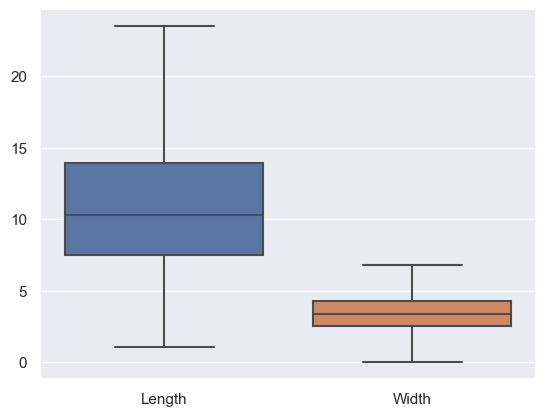

In [46]:
# Box plot of length and width without outliers
sns.boxplot(df[['Length', 'Width']], showfliers = False)
plt.show()

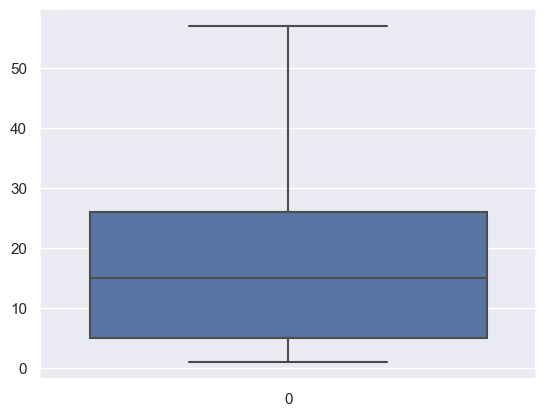

In [48]:
# Boxplot of age variable
sns.boxplot(df['age'], showfliers = False)
plt.show()

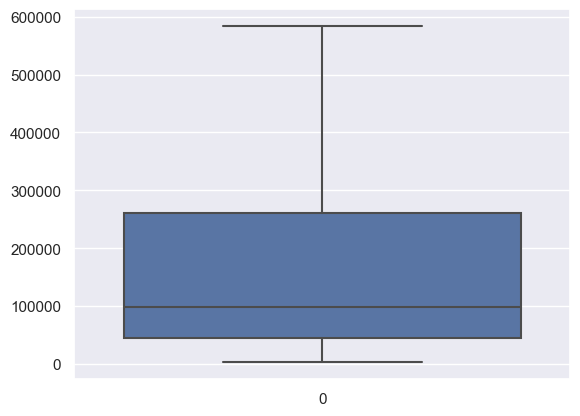

In [65]:
# Our USD Price variable

sns.boxplot(df['USD_Price'], showfliers=False)
plt.show()

## People are viewing the boats of these ten countries a lot

In [14]:
dfC = df.copy()
dfC['Country'] = dfC.Location.str.split(expand=True)[0]
dfC.groupby('Country')['Number of views last 7 days'].sum().sort_values(ascending=False)[:10]

Country
Switzerland    374431
Germany        286993
Italy          209958
Netherlands    124828
France         118098
Croatia         94999
Spain           80914
United          22857
Denmark         22355
Austria         16471
Name: Number of views last 7 days, dtype: int64

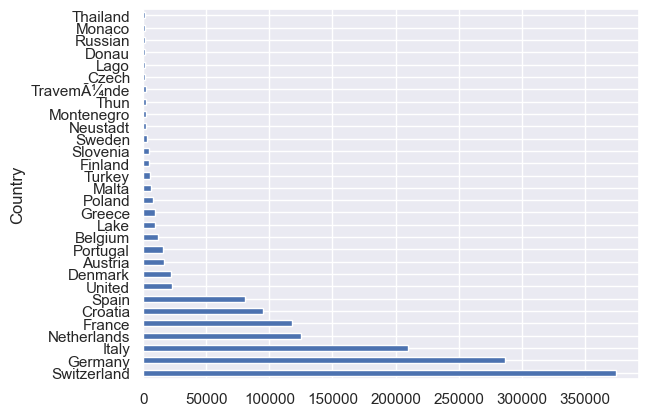

In [56]:
dfC = df.copy()
dfC['Country'] = dfC.Location.str.split(expand=True)[0]
dfC.groupby('Country')['Number of views last 7 days'].sum().sort_values(ascending=False)[:30].plot(kind='barh')
plt.show()

## Currencies in Price column

In [15]:
# Currencies

df.Price.str.split(expand=True)[0].value_counts()

EUR    8430
CHF     980
Â£      298
DKK     180
Name: 0, dtype: int64

## Year and Age

Most of the people loves the boats of either 19th century of 21st century

In [16]:
df.groupby('Year Built')['Number of views last 7 days'].sum().sort_values(ascending=False)[:10]

Year Built
2020    175872
2019     88438
1893     72302
2006     52614
2008     51351
2007     48392
2017     42420
2018     42030
2005     41354
2004     37143
Name: Number of views last 7 days, dtype: int64

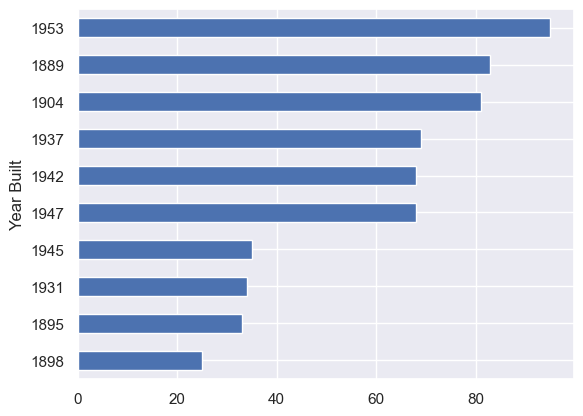

In [36]:
df.groupby('Year Built')['Number of views last 7 days'].sum().sort_values(ascending=True)[:10].plot(kind='barh')
plt.show()

Most of the people are viewing the boat of this much age

In [17]:
df.groupby('age')['Number of views last 7 days'].sum().sort_values(ascending=False)[:10].index.values

array([  2,   3, 129,  16,  14,  15,   5,   4,  17,  18])

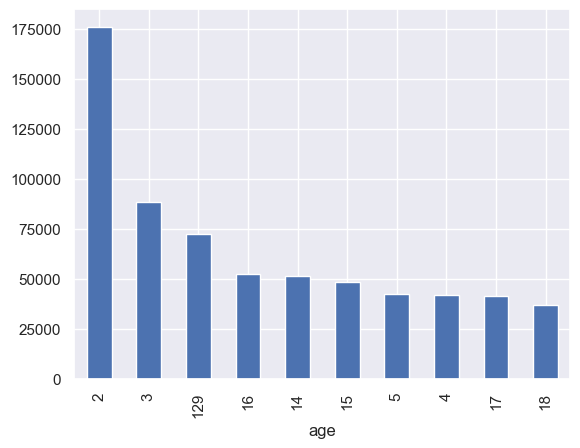

In [38]:
df.groupby('age')['Number of views last 7 days'].sum().sort_values(ascending=False)[:10].plot(kind='bar')
plt.show()

## Type of the boats which people are viewing

Most of the boots are unleaded, used and works on diesel

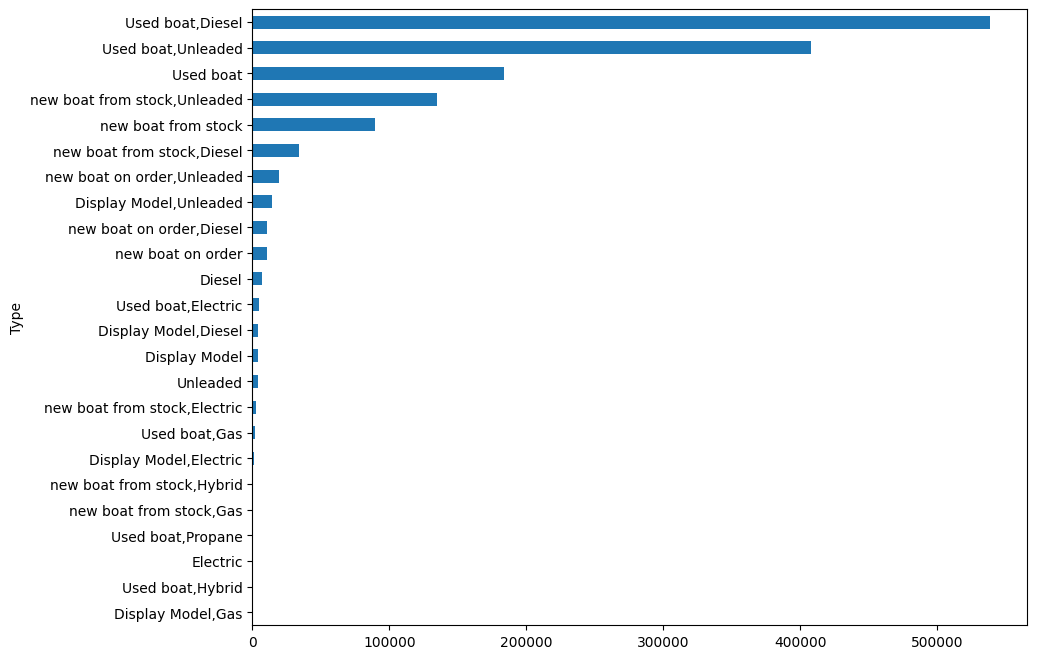

In [18]:
# Type w.r.t views

plt.figure(figsize=(10, 8))
df.groupby('Type')['Number of views last 7 days'].sum().sort_values().plot(kind='barh')
plt.show()

## Boat Type

Following are the ten most viewed boats

In [19]:
df.groupby('Boat Type')[['Number of views last 7 days']].sum().sort_values(by='Number of views last 7 days', ascending=False)[:10]

,Number of views last 7 days
Boat Type,
Motor Yacht,351659
Sport Boat,251418
Cabin Boat,131700
Flybridge,127534
Trawler,75456
Pilothouse,74730
Hardtop,65343
Bowrider,47183
Center console boat,37015


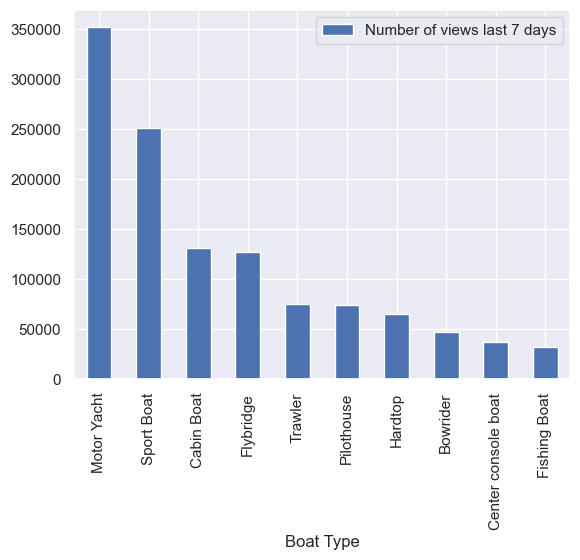

In [58]:
# The most expensive boats

df.groupby('Boat Type')[['Number of views last 7 days']].sum().sort_values(by='Number of views last 7 days', ascending=False)[:10].plot(kind='bar')
plt.show()

Following are the ten most expensive boats we have

In [20]:
df.groupby('Boat Type')[['USD_Price']].sum().sort_values(by='USD_Price', ascending=False)[:10]

,USD_Price
Boat Type,
Motor Yacht,1162792906
Mega Yacht,658054723
Flybridge,600960051
Hardtop,189406218
Trawler,137554451
Sport Boat,116584614
Pilothouse,43932246
Cabin Boat,39907101
Center console boat,31201506


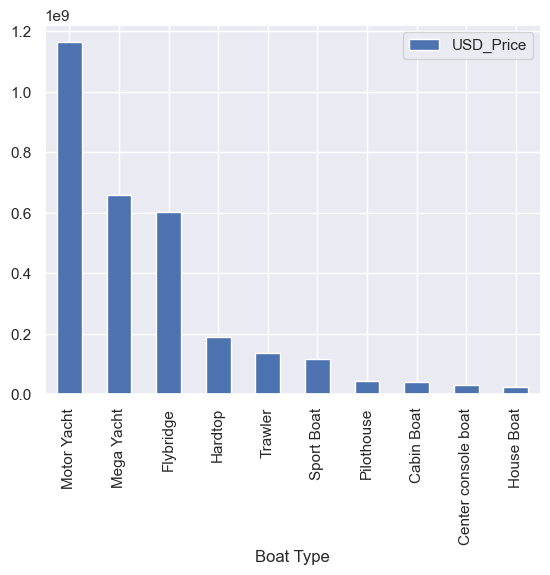

In [60]:
# Comparision of top most expensive boats

df.groupby('Boat Type')[['USD_Price']].sum().sort_values(by='USD_Price', ascending=False)[:10].plot(kind='bar')

plt.show()

## Manufacturer

Most of the most views boats we have are made up of following manufactuers

In [21]:
df.groupby('Manufacturer')[['Number of views last 7 days']].sum().sort_values(by='Number of views last 7 days', ascending=False)[:10]

,Number of views last 7 days
Manufacturer,
BÃ©nÃ©teau power boats,220466
Sunseeker power boats,51110
Jeanneau power boats,51070
Sea Ray power boats,45387
Princess power boats,39051
Bavaria power boats,35569
Bayliner power boats,34555
Cranchi power boats,32442
Azimut power boats,24339


<AxesSubplot:xlabel='Manufacturer'>

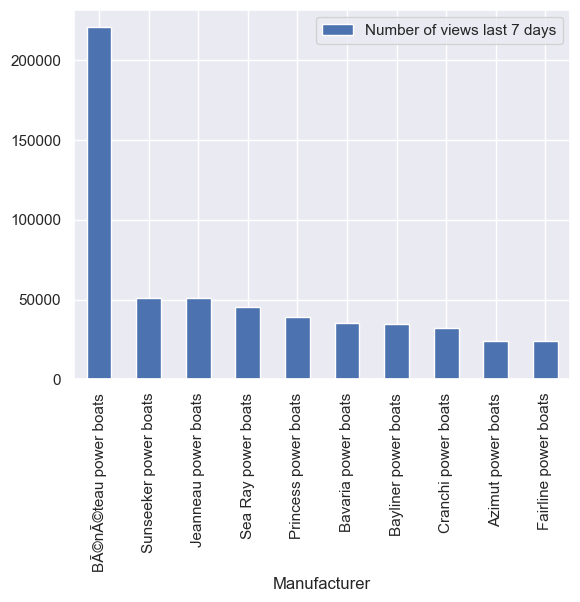

In [61]:
# Top manufacturers

df.groupby('Manufacturer')[['Number of views last 7 days']].sum().sort_values(by='Number of views last 7 days', ascending=False)[:10].plot(kind='bar')

plt.show()

## Material

Most the most viewed boats are made up of following type of material

In [22]:
df.groupby('Material')[['Number of views last 7 days']].sum().sort_values(by='Number of views last 7 days', ascending=False)[:10]

,Number of views last 7 days
Material,
GRP,1110685
Steel,125036
PVC,95968
Wood,52296
Plastic,39678
Aluminium,38816
Carbon Fiber,7953
Thermoplastic,3700
Hypalon,538


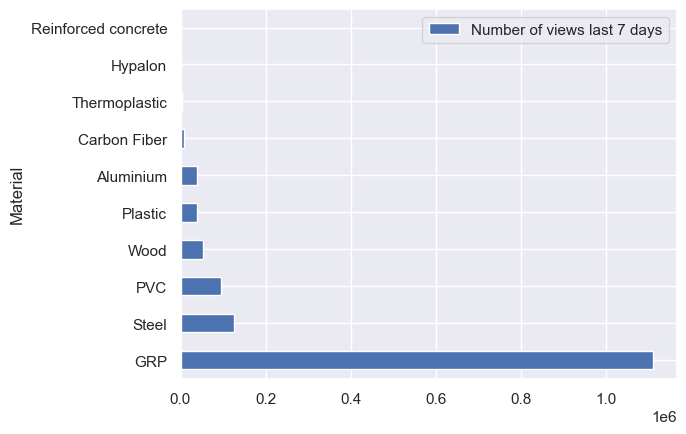

In [67]:
df.groupby('Material')[['Number of views last 7 days']].sum().sort_values(by='Number of views last 7 days', ascending=False)[:10].plot(kind='barh')
plt.show()

## Most of the expensive boats are made up of this type of material

In [23]:
df.groupby('Material')[['USD_Price']].sum().sort_values(by='USD_Price', ascending=False)[:10]

,USD_Price
Material,
GRP,2561385891
Steel,239404571
PVC,207772999
Aluminium,73170040
Wood,42251265
Carbon Fiber,16076150
Plastic,5204032
Hypalon,812354
Reinforced concrete,211596


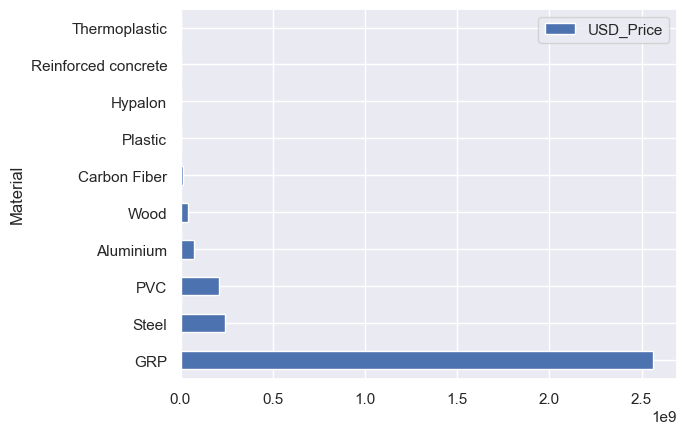

In [68]:
df.groupby('Material')[['USD_Price']].sum().sort_values(by='USD_Price', ascending=False)[:10].plot(kind='barh')
plt.show()

## Correlation between different variable

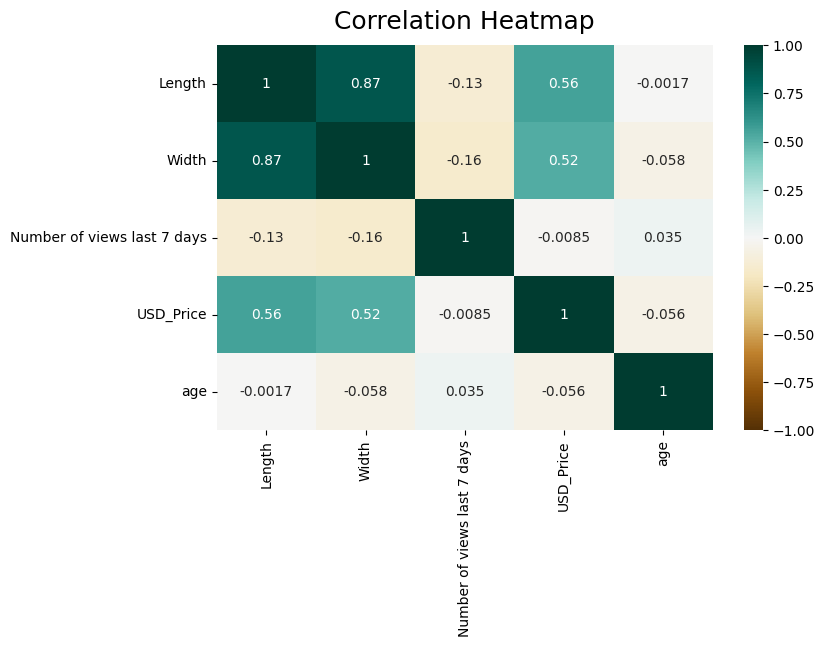

In [24]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(df.drop('Year Built', axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.show()

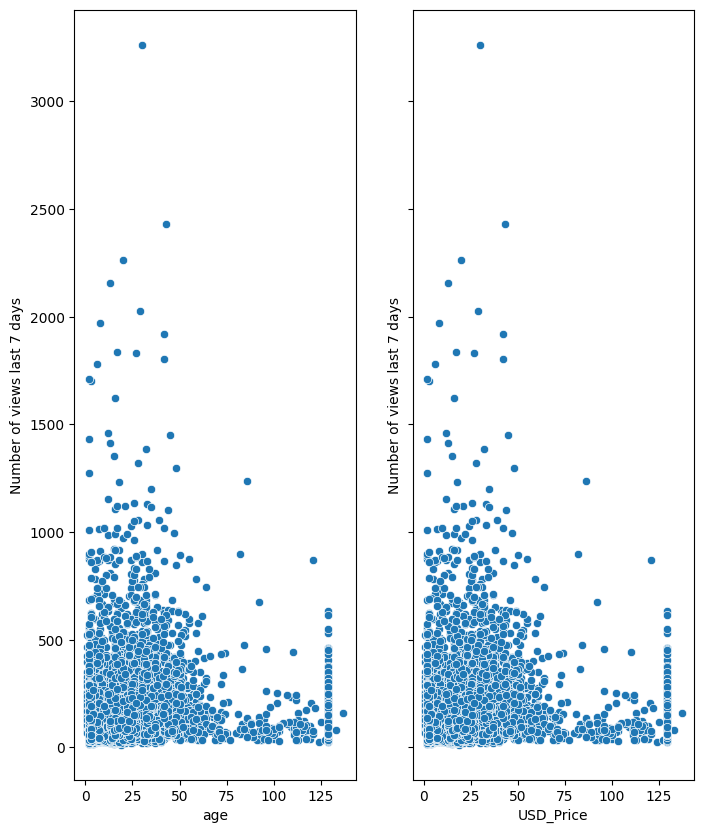

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 10))

# ax1 = fig.add_subplot()
ax1.set_xlabel('age')
ax1.set_ylabel('Number of views last 7 days')
sns.scatterplot(x = df['age'], y = df['Number of views last 7 days'], ax=ax1)


# ax2 = fig.add_subplot()
ax2.set_xlabel('USD_Price')
ax2.set_ylabel('Number of views last 7 days')
sns.scatterplot(x = df['age'], y = df['Number of views last 7 days'], ax=ax2)

plt.show()

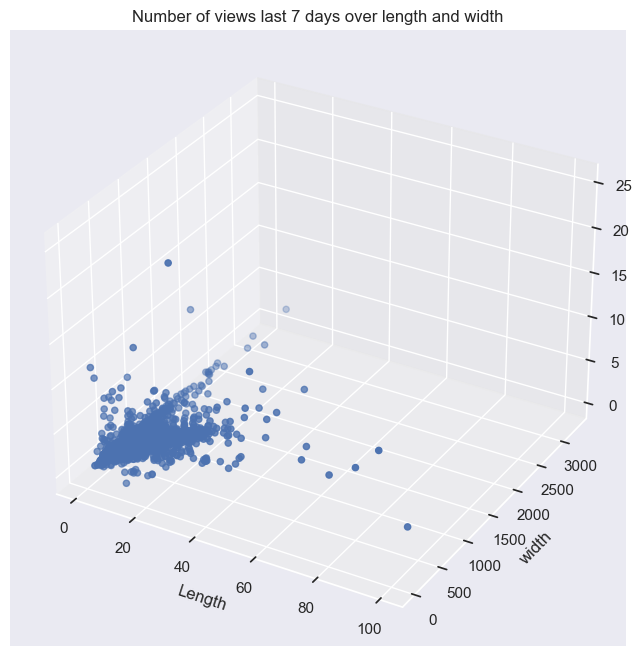

In [26]:
sns.set(style='darkgrid')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['Length']
y = df['Number of views last 7 days']
z = df['Width']

ax.set_title('Number of views last 7 days over length and width')
ax.set_xlabel('Length')
ax.set_ylabel('Number of views last 7 days')
ax.set_ylabel('width')
ax.scatter(x, y, z)

plt.show()

## Summary of Explortory data Analysis

Our Analysis shows the following results.

1. People are loving the boats from these countries a lot.
  - Switzerland' 
  - Germany
  - Italy
  - Netherlands
  - France
  - Croatia
  - Spain 
  - United
  - Denmark
  - Austria

2. We had there currencies EUR, CHF, DKK which we converted to USD prices.

3. Surprising most of the traffic we have are either on the boats of 19th century or 21st

4. The boats that are unleaded, used and works on diesel catching the eyes of people a lot.

5. The most famous boat types are as follows:

  - Motor Yacht
  - Mega Yacht
  - Flybridge
  - Hardtop	
  - Trawler	
  - Sport Boat
  - Pilothouse
  - Cabin Boat
  - Center console boat
  - House Boat

6. These most viewed boats are made by these manufactures.
  - BÃ©nÃ©teau power boats
  - Sunseeker power boats
  - Jeanneau power boats
  - Sea Ray power boats	
  - Princess power boats
  - Bavaria power boats	
  - Bayliner power boats
  - Cranchi power boats	
  - Azimut power boats	
  - Fairline power boats

7. Famous boats are made up of this material.
  - GRP	
  - Steel	
  - PVC	
  - Wood	
  - Plastic	
  - Aluminium	
  - Carbon Fiber	
  - Thermoplastic	
  - Hypalon	
  - Reinforced concrete

9. Lastly we have correlation metrics. The correlation results shows that the most of the values are not correlated to number of views at all. The hight correlation we had with the variable to be predicted is 0.035 of the age variable. Yet length and width had some correlation among each other of about 0.87 which is obvious.

# Model Development

## Preparing data

In [27]:
X = df.drop(['Price', 'Year Built', 'Number of views last 7 days'], axis=1)
X = preprocess(X) # Preprocessing the data to be used for modeling

y = df['Number of views last 7 days']

In [28]:
# Spliting the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.10, random_state=42)

## Model Building

In [29]:
# Base Model

lr = LinearRegression()

lr.fit(X_train, y_train)

print(f'Training accuracy: {lr.score(X_train, y_train):.2f}')
print(f"Testing accuracy: {lr.score(X_test, y_test):.2f}")

Training accuracy: 0.07
Testing accuracy: 0.09


In [30]:
# Best Model

xgblr = xgboost.XGBRegressor(n_estimators=10, seed=123, reg_lambda=4, gamma=4)

xgblr.fit(X_train, y_train)

print(f'Training accuracy: {xgblr.score(X_train, y_train):.2f}')
print(f"Testing accuracy: {xgblr.score(X_test, y_test):.2f}")

Training accuracy: 0.46
Testing accuracy: 0.31


## Summary of Model Development

### Data Preparation Stage

Here the data is perpared to be used for modeling purposes. The categorical data is frequency encoded and numeric variables are normalized. At last the data is split into training and testing set, 90% training and 10% testing set.

### Model Development

We chose linear regression as our baseline model MAPE was 75% quite large. And we first chose deep learning model but they were performing worse linear regression. The xgboost regressor however before very well and achieved mape of 45%. So we chose xgboost regressor as our best model

# Model Evaluation

In [31]:
xgblr_y_pred = xgblr.predict(X_test)
lr_y_pred = lr.predict(X_test)

xgblr_mse = mean_squared_error(xgblr_y_pred, y_test)
lr_mse = mean_squared_error(lr_y_pred, y_test)

xgblr_r2_score = r2_score(xgblr_y_pred, y_test)
lr_r2_score = r2_score(lr_y_pred, y_test)

lr_training_score = lr.score(X_train, y_train)
xgblr_training_score = xgblr.score(X_train, y_train)

lr_testing_score = lr.score(X_test, y_test)
xgblr_testing_score = xgblr.score(X_test, y_test)

lr_training_mape = int(mean_absolute_percentage_error(lr_y_pred, y_test)*100)
xgblr_testing_mape = int(mean_absolute_percentage_error(xgblr_y_pred, y_test)*100)

In [32]:
metrics = pd.DataFrame(
    data = [[lr_mse, xgblr_mse], 
            [lr_r2_score, xgblr_r2_score],
            [lr_training_score, xgblr_training_score],
            [lr_testing_score, xgblr_testing_score],
            [lr_training_mape, xgblr_testing_mape]],
             
    columns = ["Baseline", "Best"],

    index = ['Mean Squarred Error', 'R2 Score', 'Training score', 'Testing score',
             'Mean Absolute Percentage error']

)

metrics

,Baseline,Best
Mean Squarred Error,20855.731558,15881.422396
R2 Score,-12.433210,-1.720344
Training score,0.069253,0.460480
Testing score,0.092045,0.308602
Mean Absolute Percentage error,73.000000,45.000000


## Summary of Model Evaluation

We have our baseline model and best model. The table above shows the results the metrics we calculated with our model. Xgboost model's prediction on test set is only 45% percent away from true value, and, mean squarred error is 14634.

# Comparision to the business success criteria

## Business Success Criteria
- The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.

## Results of our model
If we look at the Mean Absolute Percentage error is 45% which means the model is only 45% away from the true value which statifies our business success criteria (not more than 50% away from true value).

## Conclusion

Our model is in accordance with our business goal.

# Final Summary

## Customer Question
The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?

## Success Criteria
- The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.

## Our Model Results
- Our model's metric results states that on average the predictions were 45% off the true number of views a listing would receive. 
- Our model has met the business criteria but not full prepared to be used for commercial reasons.

## Suggestions

- Althought MAPE is 0.45 but mse is still and also r2_score is too low we can't use it commercially.

- We'll need more data to make a perfect model to be used commercially.
